# Anosmia project analysis notebook

This notebook contains the analysis of the data collected for the Anosmia project.


***By: Sid Rafilson, Casey Lennon-Jones***

***PI: Matt Smear***




### Imports and helper functions

In [ ]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import signal
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from scipy.interpolate import interp1d
from scipy.cluster.hierarchy import linkage, leaves_list
import os


def load_sniff(sniff_file: str, num_samples: int = -1, start = 0, stop = 0, nchannels: int = 8, ch: int = 8, dtype = np.uint32) -> np.array:
    '''
    Load a specific channel from a binary sniff data file into a NumPy array.

    This function reads a binary file containing multi-channel sniff data, processes it, 
    and extracts data from a specified channel.

    Parameters:
    sniff_file (str): The path to the binary file containing sniff data.
    num_samples (int): The number of samples to read from the file.
    nchannels (int, optional): The number of channels in the sniff data. Defaults to 8.
    ch (int, optional): The channel number to extract. Defaults to 8. Channels are
                        indexed starting from 1.

    Returns:
    np.array: A NumPy array containing the data from the specified channel.

    Notes:
    - The number of samples specified is dynamic for debugging but can easily fit the entire data set with num_samples = -1.
    - Channel numbers start from 1. For instance, ch = 1 will extract the first channel.
    '''
    
    # reading in binary data
    num_samples = num_samples * nchannels
    sniff_bin = np.fromfile(sniff_file, dtype=dtype, count=num_samples)

    # ensuring equal samples from each channel
    num_complete_sets = len(sniff_bin) // nchannels
    sniff_bin = sniff_bin[:num_complete_sets * nchannels]

    # reshaping data and extracting channel which corresponds to sniff voltage
    sniff_bin = np.reshape(sniff_bin, (nchannels, -1), order='F')
    ch_index = ch - 1
    sniff = sniff_bin[ch_index, :]

    # removing start seconds from beggining, and stop from end of signal; default is 0
    start = start * 30000
    stop = stop * 30000
    if stop == 0:
        sniff = sniff[start:]  
    else:
        sniff = sniff[start: -stop]

    return sniff
    


def load_ephys(ephys_file: str, num_samples: int = -1, start = 0, stop = 0, nchannels: int = 16, dtype = np.uint32, order = 'F') -> np.array:
    '''
    Load and reshape binary electrophysiology data into a NumPy array.

    This function is designed to read binary files containing electrophysiology 
    (ephys) data. It loads the specified number of samples from the file and 
    reshapes them into a 2D NumPy array, where each row represents a channel.

    Parameters:
    ephys_file (str): Path to the binary file containing electrophysiology data.
    num_samples (int): Number of samples to read from the file.
    nchannels (int, optional): Number of channels in the ephys data. Defaults to 16.

    Returns:
    np.array: A 2D NumPy array of the electrophysiology data, reshaped into
              (nchannels, number_of_samples_per_channel).
    '''
  
    # reading in binary data
    num_samples = num_samples * nchannels
    ephys_bin = np.fromfile(ephys_file, dtype=dtype, count = num_samples)
    
    # ensuring equal samples from each channel
    num_complete_sets = len(ephys_bin) // nchannels
    ephys_bin = ephys_bin[:num_complete_sets * nchannels]

    # reshape 1d array into nchannels x num_samples NumPy array
    ephys_data = np.reshape(ephys_bin, (nchannels, -1), order=order)

    # removing start seconds from beggining, and stop from end of signal; default is 0
    start = start * 30000
    stop = stop * 30000

    if stop == 0:
        ephys = ephys_data[:, start:]
    else:
        ephys = ephys_data[:, start: -stop]

    return ephys



def resample_sniff(sniff: np.array, original_rate = 30000, target_rate = 1000) -> np.array:
    '''
    Resample a sniff signal from an original rate to a target rate.

    This function applies a decimation process to a sniff signal, which is useful in 
    situations where lower sampling rates are sufficient or desired for analysis. The 
    decimation is performed using a Finite Impulse Response (FIR) filter with a Hamming 
    window to reduce aliasing effects.

    Parameters:
    sniff (np.array): The sniff signal to be resampled, represented as a NumPy array.
    original_rate (int, optional): The original sampling rate of the signal in Hz. Defaults to 30000 Hz.
    target_rate (int, optional): The desired sampling rate of the signal in Hz. Defaults to 1000 Hz.

    Returns:
    np.array: The resampled sniff signal.
    '''

    # calculating resample factor
    resample_factor = original_rate // target_rate

    # calculating new length of resampled signal
    if 0 != sniff.shape[0] % resample_factor:
        sniff = sniff[:-(sniff.shape[0] % resample_factor)]

    # calculating new length of resampled signal
    print(f'Resampling from length {sniff.shape[0]}')
    new_length = sniff.shape[0]//resample_factor

    # applying decimation to the signal
    resampled_sniff = np.zeros(new_length)
    resampled_sniff = signal.decimate(sniff, resample_factor, ftype = 'fir')

    return resampled_sniff
    


def resample_ephys(ephys: np.array, nchannels = 16, original_rate = 30000, target_rate = 1000) -> np.array:
    '''
    Resample multi-channel electrophysiology (ephys) data from an original sampling rate to a target rate.

    This function applies a decimation process to each channel of a multi-channel ephys signal. 
    It uses a 30-point Finite Impulse Response (FIR) filter with a Hamming window to mitigate 
    aliasing effects during resampling.

    Parameters:
    ephys (np.array): A 2D NumPy array representing the ephys data, with shape (nchannels, number_of_samples).
    nchannels (int, optional): Number of channels in the ephys data. Defaults to 16.
    original_rate (int, optional): Original sampling rate of the ephys data in Hz. Defaults to 30000 Hz.
    target_rate (int, optional): Target sampling rate in Hz. Defaults to 1000 Hz.

    Returns:
    np.array: A 2D NumPy array of the resampled ephys data, with the same number of channels 
              and a reduced number of samples per channel.
    '''

    # calculating resample factor
    resample_factor = original_rate // target_rate

    # removing samples from the end of the signal if the length is not divisible by the resample factor
    if 0 != ephys.shape[1] % resample_factor:
        ephys = ephys[:, :-(ephys.shape[1] % resample_factor)]

    # calculating new length of resampled signal
    print(f'Resampling Ephys from length {ephys.shape[1]}')
    new_length = ephys.shape[1]//resample_factor

    # applying decimation to the signal
    resampled_ephys = np.zeros((nchannels, new_length))
    for ch in range(nchannels):
        resampled_ephys[ch, :] = signal.decimate(ephys[ch,:], resample_factor, ftype = 'fir')

    return resampled_ephys



def find_inhales(data: np.array, window_length = 51, polyorder = 5, min_peak_prominance = 75) -> np.array:
    '''
    Smooth a  signal using the Savitzky-Golay method and locate inhalation times using peak finding.

    This function first applies a Savitzky-Golay filter to smooth the input signal. 
    It then uses a peak finding algorithm to identify the times of inhalations, which are 
    indicated by prominent peaks in the smoothed signal. Optionally, the function can also 
    plot the original and smoothed signals along with the identified peaks.

    Parameters:
    data (np.array): The signal to be processed, represented as a NumPy array.
    window_length (int, optional): The length of the filter window. Defaults to 101.
    polyorder (int, optional): The order of the polynomial used to fit the samples. Defaults to 9.
    min_peak_prominance (int, optional): The minimum prominence of a peak to be considered 
                                         an inhalation. Defaults to 50.
    show (bool, optional): If True, display a plot of the original and smoothed signals with peaks. 
                           Defaults to False.

    Returns:
    tuple: A tuple containing two elements:
           - locs (np.array): An array of indices where inhalation peaks are located.
           - smoothed_sniff (np.array): The smoothed sniff signal.
    '''

    smoothed_data = signal.savgol_filter(data, window_length, polyorder)
    locs, properties = signal.find_peaks(smoothed_data, height = (None, None), prominence = min_peak_prominance)
    

    return locs, smoothed_data, properties



def sniff_lock_lfp(locs: np.array, ephys: np.array, window_size = 1000, nsniffs = 512, beg = 3000, method = 'zscore') -> np.array:
    '''
    Aligns local field potential (LFP) signals with sniff inhalation times and constructs a 3D array of z-scored LFP activity.

    This function identifies segments of LFP signals corresponding to inhalation times (specified by 'locs') and 
    standardizes these segments across channels. The output is a 3D array where each 'slice' corresponds to the LFP 
    activity surrounding a single sniff event, with data from all channels.

    Parameters:
    locs (np.array): Array of sniff inhalation times (indices).
    ephys (np.array): 2D array of electrophysiological data with shape (nchannels, number_of_samples).
    nchannels (int, optional): Number of channels in the ephys data. Defaults to 16.
    window_size (int, optional): The size of the window around each sniff event to consider for LFP activity. Defaults to 1000.
    nsniffs (int, optional): Number of sniff events to process. Defaults to 512.
    beg (int, optional): Starting index to begin looking for sniff events. Defaults to 3000.

    Returns:
    sniff_activity (np.array): A 3D NumPy array with shape (nsniffs, window_size, nchannels). Each 'slice' of this array 
              represents the z-scored LFP activity around a single sniff event for all channels.
    loc_set (np.array): An array of indices where inhalation peaks are located.

    Raises:
    ValueError: If the 'locs' array does not contain enough data after the specified 'beg' index for the required number of sniffs.
    '''


    # finding number of channels
    nchannels = ephys.shape[0]


    # finding the set of inhalation times to use
    if nsniffs == 'all':
        loc_set = locs[5:-5]
        nsniffs = len(loc_set)
    elif isinstance(nsniffs, int):
        first_loc = np.argmax(locs >= beg)
        loc_set = locs[first_loc: first_loc + nsniffs]
    else:
        raise ValueError("nsniffs must be either 'all' or an integer.")

    # checking if locs array has enough data for the specified range
    if isinstance(nsniffs, int):
        if len(loc_set) < nsniffs:
            raise ValueError("locs array does not have enough data for the specified range.")
        
    # propogates an nx2 array containing times half the window size in both directions from inhalation times
    windows = np.zeros((nsniffs, 2), dtype=int)
    for ii in range(nsniffs):
        win_beg = loc_set[ii] - round(window_size/2)
        win_end = loc_set[ii] + round(window_size/2)
        windows[ii] = [win_beg, win_end]

    if method == 'zscore':
        # finds and saves zscored ephys data from each channel for each inhalaion locked time window
        sniff_activity = np.zeros((nchannels, nsniffs, window_size))
        for ii in range(nsniffs):
            for ch in range(nchannels):
                win_beg, win_end = windows[ii]
                data = ephys[ch, win_beg:win_end]
                data_mean = np.mean(data)
                data_std = np.std(data)
                zscore_data = (data - data_mean) / data_std
                if len(data) < window_size:
                    data = np.pad(data, (0, window_size - len(data)), mode = 'constant', constant_values = 0)
                    print('!!! padding !!!')
                sniff_activity[ch,ii,:] = zscore_data

    elif method == 'none':
        sniff_activity = np.zeros((nchannels, nsniffs, window_size))
        for ii in range(nsniffs):
            for ch in range(nchannels):
                win_beg, win_end = windows[ii]
                data = ephys[ch, win_beg:win_end]
                if len(data) < window_size:
                    data = np.pad(data, (0, window_size - len(data)), mode = 'constant', constant_values = 0)
                    print('!!! padding !!!')
                sniff_activity[ch,ii,:] = data

    return sniff_activity, loc_set



def sort_lfp(sniff_activity, locs):
    '''sorts the sniff locked lfp trace by sniff frequency'''

    # finding data shape
    nchannels = sniff_activity.shape[0]
    nsniffs = sniff_activity.shape[1]
    window_size = sniff_activity.shape[2]
    
    sorted_activity = np.zeros((nchannels, nsniffs-1, window_size))
    
    # finding sniff frequencies by inhalation time differences (we lose the last sniff)
    freqs = np.diff(locs)

    # sorting the ephys data and frequency values according to these times
    sort_indices = np.argsort(freqs)
    sorted_activity[:, :, :] = sniff_activity[:, sort_indices, :]
    sorted_freqs = freqs[sort_indices]
    sorted_freqs = 1 / (sorted_freqs / 1000)

    return sorted_activity, sorted_freqs




In [ ]:
map_file = r"E:\PlaceCells\4134\3\channel_map.npy"
position_file = r"E:\PlaceCells\4134\3\channel_positions.npy"
map = np.load(map_file, allow_pickle=True)
position = np.load(position_file, allow_pickle=True)
print(map)
print(position)

In [15]:
data_file = r"C:\Users\smearlab\clickbait-ephys\open-ephys\2025-02-10_17-04-35_6002\Record Node 104\experiment1\recording1\continuous\Acquisition_Board-102.Rhythm Data\continuous.dat"
ephys = load_ephys(data_file, nchannels = 40, dtype = np.int16, order = 'F')

In [16]:
# Removing ADC channels and keeping only the ephys channels
ntetrodes = 8
ephys = ephys[:ntetrodes * 4,:]

# Scaling the data by the gain factor from Open Ephys to convert to mV
ephys = 0.1949999928474426 * ephys

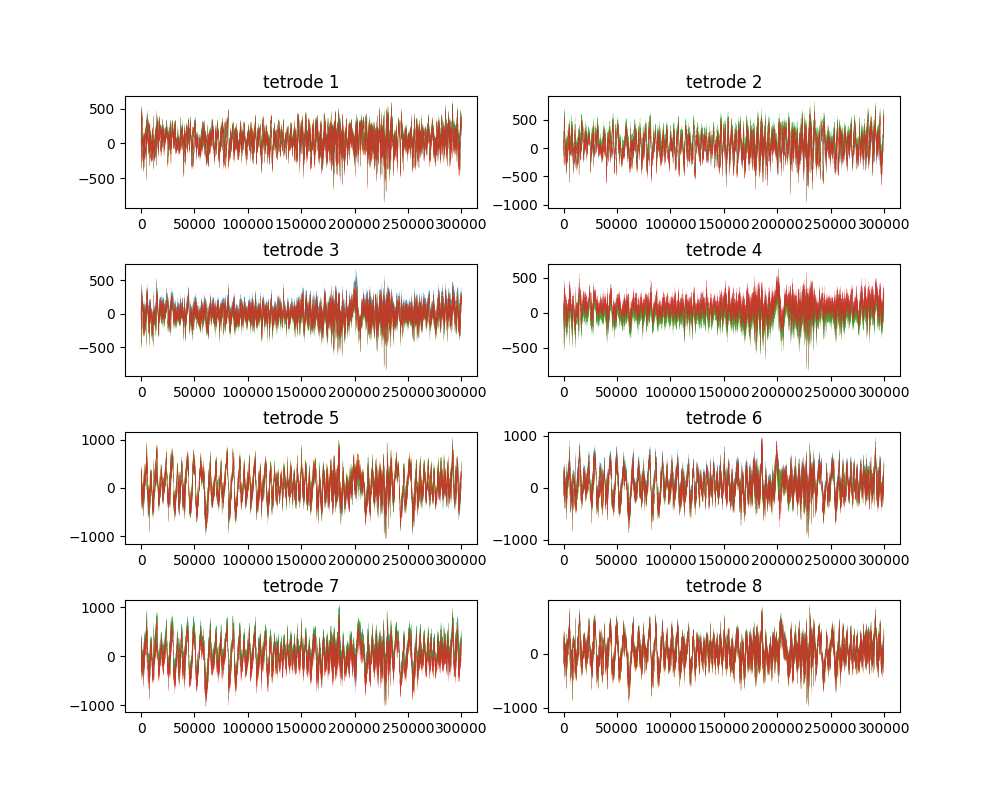

In [ ]:
t_start = 100000
t_window = 30000

plt.figure(figsize=(14, 8))
for i in range(ntetrodes):
    plt.subplot(4, 2, i+1)
    # add vertical padding between subplots
    plt.subplots_adjust(hspace=0.5)
    plt.title(f'tetrode {i+1}')
    for j in range(4):
        plt.plot(ephys[i*4+j,t_start * 10 :(t_start + t_window) * 10], linewidth = 0.1, alpha = 0.8)

In [18]:
# badnpass filter
sos = signal.butter(3, [300, 6000], btype='bandpass', fs=30000, output='sos')
ephys = signal.sosfiltfilt(sos, ephys, axis = 1)

# median common avg reference by region
ephys[:16] = ephys[:16] - np.median(ephys[:16], axis = 0)
ephys[16:] = ephys[16:] - np.median(ephys[16:], axis = 0)

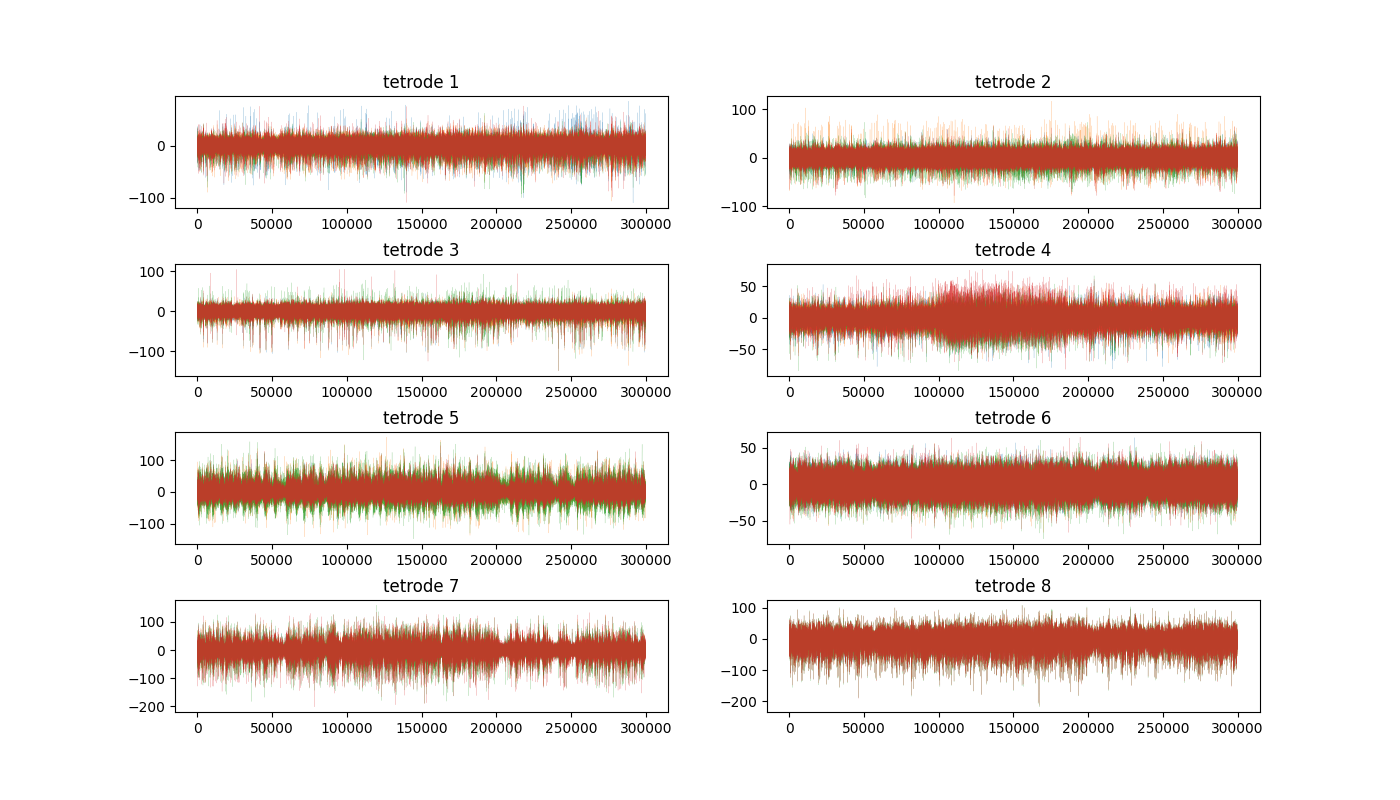

In [22]:
t_start = 100000
t_window = 30000

plt.figure(figsize=(14, 8))
for i in range(ntetrodes):
    plt.subplot(4, 2, i+1)
    # add vertical padding between subplots
    plt.subplots_adjust(hspace=0.5)
    plt.title(f'tetrode {i+1}')
    for j in range(4):
        plt.plot(ephys[i*4+j,t_start * 10 :(t_start + t_window) * 10], linewidth = 0.1, alpha = 0.8)

In [ ]:
# Remove artifacts
for ch in range(ephys.shape[0]):
    bad_indicies = np.where(np.abs(ephys[ch,:]) > 200)[0]
    for i in bad_indicies:
        ephys[ch,i] = 0


### Saving the preprocessed data (it works!)

In [23]:
#saving ephys data as binary file 
ephys = ephys.reshape(-1, order = 'F')
ephys.astype(np.int16).tofile(r"C:\Users\smearlab\clickbait-ephys\kilosort_test\6002_7.dat")

### Loading the data

In [ ]:
data_dir = r"C:\Users\smearlab\clickbait-ephys\open-ephys"
mouse = '6000'
session = '8'

nch = 32


# finding mouse directories
mouse_dirs = os.listdir(data_dir)
print(f"Mouse directories in the main data directory: {mouse_dirs}")


# finding sessions for a specific mouse
sessions = os.listdir(os.path.join(data_dir, mouse))
print(f"Sessions for mouse {mouse}: {sessions}")


# loading ephys and sniff data files
files = os.listdir(os.path.join(data_dir, mouse, session))
#ephys_file = [file for file in files if file.endswith('Ephys.bin')][0]
ephys_file = [file for file in files if file.endswith('nch32.bin')][0]
ephys_file = os.path.join(data_dir, mouse, session, ephys_file)
#sniff_file = [file for file in files if file.endswith('ADC.bin')][0]
sniff_file = [file for file in files if file.endswith('nch8.bin')][0]
sniff_file = os.path.join(data_dir, mouse, session, sniff_file)
print(f"Ephys file: {ephys_file}\nSniff file: {sniff_file}\n\n")


# loading raw sniff and ephys data
sniff = load_sniff(sniff_file, nchannels = 8, ch = 8, dtype = np.int16)
ephys = load_ephys(ephys_file, nchannels = nch, dtype = np.int16)
print(f'Data Loaded\n---------------------------------------\nlength of sniff signal: {sniff.shape[0]}\nShape of ephys signal: {ephys.shape}\n')


# filtering and resampling ephys to get LFP
sos = signal.butter(6, 300, 'low', fs = 30_000, output = 'sos')
lfp = resample_ephys(signal.sosfiltfilt(sos, ephys, axis = 1), nchannels = nch, original_rate = 30_000, target_rate = 1_000)
print(f'\nLFP filtered and resampled\n-------------------------\nShape of LFP signal: {lfp.shape}\n')


# resampling sniff signal to match LFP
sniff_resampled = resample_sniff(sniff, original_rate = 30_000, target_rate = 1_000)
print(f'Sniff resampled\n-----------------------------------\nLength of resampled sniff signal: {sniff_resampled.shape[0]}\n')


# filtering ephys to get spikes
sos = signal.butter(10, 1_000, 'high', fs = 30_000, output = 'sos')
spikes = signal.sosfiltfilt(sos, ephys, axis = 1)
print(f'Spikes filtered\n-----------------------------------\nShape of spikes signal: {spikes.shape}\n')


# time vectors
time_lfp = np.arange(0, sniff_resampled.shape[0], 1) / 1_000
time_spikes = np.arange(0, spikes.shape[1], 1) / 30_000
print(f'\nTime vectors created\n-----------------------------------\nlength of time vector for LFP: {time_lfp.shape[0]}\nlength of time vector for spikes: {time_spikes.shape[0]}\n')



### Finding the pairwise correlations between channels to verify tetrode to channel mapping

In [ ]:
save_dir = os.path.join(r"E:\anosmia\figs", mouse, session)

# Compute pairwise correlations
correlation_matrix = np.corrcoef(ephys)

# Perform hierarchical clustering
linkage_matrix = linkage(correlation_matrix, method='average')  # Use average linkage (or 'single', 'complete', etc.)
ordered_indices = leaves_list(linkage_matrix)  # Get the reordering of indices based on the clustering

# Reorder the correlation matrix
sorted_corr_matrix = correlation_matrix[ordered_indices, :][:, ordered_indices]

# Get the channel labels after sorting
sorted_channel_labels = [f"Channel {i}" for i in ordered_indices]

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis')
plt.colorbar(label='Correlation')
plt.title('Channel Correlation Matrix')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.savefig(os.path.join(save_dir, 'correlation_matrix.png'))
plt.close()

# Visualize sorted correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(sorted_corr_matrix, cmap='viridis')
plt.colorbar(label='Correlation')
plt.title('Sorted Channel Correlation Matrix')
plt.xticks(ticks=np.arange(len(sorted_channel_labels)), labels=sorted_channel_labels, rotation=90)
plt.yticks(ticks=np.arange(len(sorted_channel_labels)), labels=sorted_channel_labels)
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.savefig(os.path.join(save_dir, 'sorted_correlation_matrix.png'))
plt.close()



### Filtering the data

In [ ]:
filters = {'theta': (2, 12), 'beta': (25, 45), 'gamma': (65, 85)}

for key, value in tqdm(filters.items(), desc='Filtering LFP signals'):
    sos = signal.butter(6, value, 'band', fs=1000, output='sos')
    filtered = signal.sosfiltfilt(sos, lfp, axis=1)
    globals()[key] = filtered
    del sos

print(f'\nLFP signals filtered\n-----------------------------------\nShape of LFP signal: {lfp.shape}\n')
gamma_envelope = np.abs(signal.hilbert(gamma, axis=1))
print(f'Gamma envelope calculated\n-----------------------------------\nlength of gamma envelope signal: {gamma_envelope.shape[1]}\n')



### Plotting the LFPs with sniff

In [ ]:
save_dir = os.path.join(r"E:\anosmia\figs", mouse, session)

lfps = {'raw': lfp, 'theta': theta, 'beta': beta, 'gamma': gamma, 'gamma_envelope': gamma_envelope}

fig_path = os.path.join(save_dir, 'sniff_lfp')
if not os.path.exists(fig_path):
    os.makedirs(fig_path)



for key, value in tqdm(lfps.items(), desc='Plotting LFPs'):

    start = 0
    end = 3_000

    save_path = os.path.join(fig_path, key)
    if not os.path.exists(save_path):
        os.makedirs(save_path)



    for j in range(10):
        
        fig, axs = plt.subplots(nch + 1, 1, figsize=(17, 30), sharex=True)
        sns.despine()
        axs[0].plot(time_lfp[start:end], sniff_resampled[start:end], color='black')
        axs[0].set_title('Sniff')
        axs[0].set_ylabel('Voltage (AU)')
        axs[0].set_yticks([])
        for i in range(nch):
            mi = mutual_info_regression(time_lfp[start:end, None], value[i, start:end])
            axs[i+1].plot(time_lfp[start:end], value[i, start:end], color='black')
            axs[i+1].set_title(f'Channel {i+1}: MI = {mi[0]:.2f} ')
            axs[i+1].set_ylabel('Voltage (AU)')
            axs[i+1].set_yticks([])
        axs[-1].set_xlabel('Time (s)')
        fig.suptitle(f'{key} LFPs')
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        fig.savefig(os.path.join(save_path, f'{key}_lfp_{j}.png'))
        plt.close(fig)

        start += 3_000
        end += 3_000


### Plotting the Spikes with sniff

In [ ]:

fig_path = os.path.join(save_dir, 'sniff_spikes')
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

start = 0
end = start + 90_000

for j in tqdm(range(10), desc='Plotting Spikes'):

    fig, axs = plt.subplots(nch + 1, 1, figsize=(17, 30), sharex=True)
    sns.despine()
    axs[0].plot(time_spikes[start:end], sniff[start:end], color = 'black', linewidth=0.5)
    axs[0].set_title('Sniff Data')
    axs[0].set_ylabel('Voltage (mV)')
    for i in range(1, nch):
        mi = mutual_info_regression(time_spikes[start:end, None], spikes[i-1, start:end])
        axs[i].plot(time_spikes[start:end], spikes[i-1, start:end], color ='black', linewidth=0.1)
        axs[i].set_title(f'Channel {i}: MI = {mi[0]:.2f}')
        axs[i].set_ylabel('Voltage (mV)')
    axs[nch].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.savefig(f'{fig_path}\\sniff_spikes{j}.png', dpi=300)
    plt.close()

    start += 90_000
    end += 90_000


### Finding inhalation times and plotting the sniff frequency histogram

In [ ]:
locs, _, _ = find_inhales(sniff_resampled)
freqs = 1000 / np.diff(locs)
freqs = freqs[(freqs < 16) & (freqs > 0.5)]


plt.figure(figsize=(10, 6))
sns.histplot(freqs, bins = 50, kde = True)
plt.title('Sniff Frequency Distribution')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.savefig(f'{save_dir}\\sniff_freqs.png', dpi=300)
plt.close()

### Building sniff aligned LFP rasters

In [ ]:


fig_path = os.path.join(save_dir, 'sniff rasters')
if not os.path.exists(fig_path):
    os.makedirs(fig_path)


lfps = {'raw': lfp, 'theta': theta, 'beta': beta, 'gamma': gamma, 'gamma_envelope': gamma_envelope, 'spikes': spikes}

for key, value in tqdm(lfps.items(), desc='Plotting LFPs'):

    raster_path = os.path.join(fig_path, key)
    if not os.path.exists(raster_path):
        os.makedirs(raster_path)

    if key == 'spikes':
        activity, locs = sniff_lock_lfp(locs * 30, value)
    else:
        activity, locs = sniff_lock_lfp(locs, value)
        
    sorted_activity, sorted_freqs = sort_lfp(activity, locs)

    vmax = np.percentile(sorted_activity, 95.5)

    for i in range(nch):
        plt.figure(figsize=(10, 6))
        sns.heatmap(sorted_activity[i, :, :], cmap='seismic', robust=True, vmax=vmax, vmin=-vmax)
        plt.title(f'Channel {i+1}')
        plt.xticks([])
        plt.yticks([])
        plt.savefig(f'{raster_path}\\channel_{i+1}.png', dpi=300)
        plt.close()





### Normalizing spike data and looking for threshold crossings

In [ ]:
# normalizing spiking data
normalized_spiking = stats.zscore(spikes, axis=1)



In [ ]:


threshold = 5
crossings = np.zeros(normalized_spiking.shape)

# looping through each channel and finding threshold crossings (spike times)
for i in tqdm(range(nch), desc='Finding Spikes'):
    data = normalized_spiking[i, :]
    current_crossings = np.where(np.diff(data > threshold) == 1)
    crossings[i, current_crossings] = 1



In [ ]:

fig_path_waves = os.path.join(save_dir, 'spike_waves')
fig_path_heatmaps = os.path.join(save_dir, 'spike_heatmaps')

if not os.path.exists(fig_path_waves):
    os.makedirs(fig_path_waves)
if not os.path.exists(fig_path_heatmaps):
    os.makedirs(fig_path_heatmaps)

waves = [[] for _ in range(nch)]

# Collect waveforms and plot line plots
for ch in tqdm(range(nch)):
    spike_times = np.where(crossings[ch, :] == 1)[0]
    plt.figure(figsize=(10, 6))
    if len(spike_times) > 0:
        lw = 0.1 if len(spike_times) > 100 else 0.5
        for spike_time in spike_times:
            start = spike_time - 15
            end = spike_time + 15
            if start >= 0 and end < normalized_spiking.shape[1]:  # Check bounds
                current_spike = normalized_spiking[ch, start:end]
                plt.plot(current_spike, linewidth=lw, alpha=0.2)
                if current_spike.shape[0] == 30:
                    waves[ch].append(current_spike)

        plt.xticks([0, 5, 10, 15, 20, 25, 30], ['-1', '-2/3', '-1/3', '0', '1/3', '2/3', '1'])
        plt.title(f'Channel {ch+1} Spike Waves')
        plt.xlabel('Time lag (ms)')
        plt.ylabel('Voltage (z-score)')
        sns.despine()
        plt.savefig(f'{fig_path_waves}/spike_waves_{ch+1}.png', dpi=300)
        plt.close()
    else:
        plt.close()





In [ ]:
# Increasing the time resolution of the spike waves using interpolation
interpolated_waves = [[] for _ in range(nch)]
for ch in tqdm(range(nch)):
    for wave in waves[ch]:
        x = np.arange(0, 30)
        f = interp1d(x, wave, kind='cubic')
        x_new = np.linspace(0, 29, 1000)  # Increase the resolution
        y_new = f(x_new)
        interpolated_waves[ch].append(y_new)

In [ ]:


# Create and plot density heatmaps
for ch in range(nch):
    current_data = np.array(interpolated_waves[ch])
    tqdm.write(f'Channel {ch+1} has {current_data.shape} shape')
    if current_data.shape[0] == 0:
        continue

    # Create a 2D histogram of the spike data
    time_bins = 1000  # Number of time bins for increased resolution
    voltage_bins = 100  # Number of voltage bins
    hist_data, xedges, yedges = np.histogram2d(
        np.tile(np.arange(current_data.shape[1]), current_data.shape[0]),
        current_data.ravel(),
        bins=[time_bins, voltage_bins],
        range=[[0, 1000], [current_data.min(), current_data.max()]]
    )

    plt.figure(figsize=(10, 6))
    sns.heatmap(hist_data.T, cmap='seismic', robust=True, cbar=True)
    plt.xticks(ticks=np.linspace(0, 1000, 7), labels=['-1', '-2/3', '-1/3', '0', '1/3', '2/3', '1'])
    plt.yticks(ticks=np.linspace(0, voltage_bins, 11), labels=np.round(np.linspace(current_data.min(), current_data.max(), 11), 2))
    plt.gca().invert_yaxis()
    plt.title(f'Channel {ch+1} Spike Density Heatmap')
    plt.xlabel('Time lag (ms)')
    plt.ylabel('Voltage (z-score)')
    plt.savefig(f'{fig_path_heatmaps}/spike_heatmap_{ch+1}.png', dpi=300)
    plt.close()

